Repetition-5 Example
===

In [1]:
import os
from qce_interp import (
    DataManager,
    QubitIDObj,
    ParityType,
    Surface17Layer,
    IErrorDetectionIdentifier,
    ILabeledErrorDetectionIdentifier,
    ErrorDetectionIdentifier,
    LabeledErrorDetectionIdentifier,
    ISyndromeDecoder,
    ILabeledSyndromeDecoder,
    Distance5LookupTableDecoder,
    LabeledSyndromeDecoder,
)
from definitions import UNITDATA_DIR
example_file_path = os.path.join(UNITDATA_DIR, 'example_repetition_code_distance_5.hdf5')

Construct Data Manager
===
This class is responsible to construct the experiment index kernel based on metadata such as the number of QEC-rounds, involved qubits, device layout, expected initial stabilizer parities (based on prepared data-qubit state) and whether heralded initialization is used.

Note: reading a large .hdf5 file might take a few minutes. (approx. 2 minutes for 6Gb file)

In [2]:
data_manager: DataManager = DataManager.from_file_path(
    file_path=example_file_path,
    rounds=list(range(1, 60 + 1)),
    heralded_initialization=True,
    qutrit_calibration_points=True,
    involved_data_qubit_ids=[QubitIDObj('D7'), QubitIDObj('D4'), QubitIDObj('D5'), QubitIDObj('D6'), QubitIDObj('D3')],
    involved_ancilla_qubit_ids=[QubitIDObj('Z3'), QubitIDObj('Z1'), QubitIDObj('Z4'), QubitIDObj('Z2')],
    expected_parity_lookup={
        QubitIDObj('Z3'): ParityType.ODD,
        QubitIDObj('Z1'): ParityType.ODD, 
        QubitIDObj('Z4'): ParityType.ODD, 
        QubitIDObj('Z2'): ParityType.ODD,
    },
    device_layout=Surface17Layer(),
)

Processing data file: 100%|██████████| 9/9 [00:28<00:00,  3.18s/it]


Construct Error Detection Identifier
===
This class follows the `IErrorDetectionIdentifier` interface and is responsible providing processed experimental data such as:
- Binary (or ternary) classification of qubit (qutrit) measurements. 
- Post-selecting (masking) data based on heralded initialization or leakage events (2nd-state readout).
- Stabilizer parities.
- Computed parities from final data-qubit measurements.
- Stabilizer defects.

Each method output follows the following convention:
Output arrays are 3D tensors (N, M, P) where,
- N is the number of measurement repetitions.
- M is the number of stabilizer repetitions.
- P is the number of qubit elements.
    Where:
    - S is the number of stabilizer qubits.
    - D is the number of data qubits.

Note: It is possible to wrap `IErrorDetectionIdentifier` with `LabeledErrorDetectionIdentifier` to obtain the same method outputs but formatted using `xarray.DataArray`.

In [3]:
error_identifier: IErrorDetectionIdentifier = data_manager.get_error_detection_classifier(
    use_heralded_post_selection=True,
    use_computational_parity=True,
)

# Optional labeled wrapper
labeled_error_identifier: ILabeledErrorDetectionIdentifier = LabeledErrorDetectionIdentifier(
    error_identifier,
)

Construct Basic LUT Decoder
===
From this point we can write decoder functionality that uses `IErrorDetectionIdentifier` as an interface to the experiment data. The decoder requires no knowledge for example on post-selection and state classification.
The following LUT decoder class implements a general `ISyndromeDecoder`.

In [4]:
decoder: ISyndromeDecoder = Distance5LookupTableDecoder(
    error_identifier,
)

# Optional labeled wrapper
labeled_decoder: ILabeledSyndromeDecoder = LabeledSyndromeDecoder(
    decoder
)

Visualization
===
Lets use this framework to visualize some commong metrics

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Computational parity and refocusing corrected State'}, ylabel='Rounds'>)

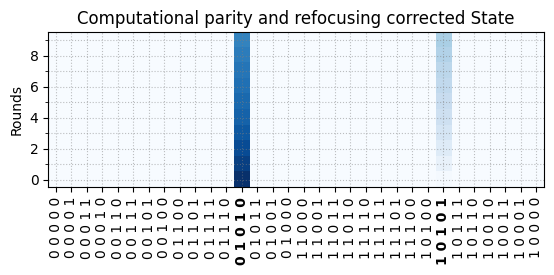

In [5]:
from qce_interp.visualization import plot_state_evolution

plot_state_evolution(
    syndrome_decoder=decoder,
    target_state=[0, 1, 0, 1, 0],
    included_rounds=list(range(1, 11)),
)

(<Figure size 640x480 with 3 Axes>, <Axes: >)

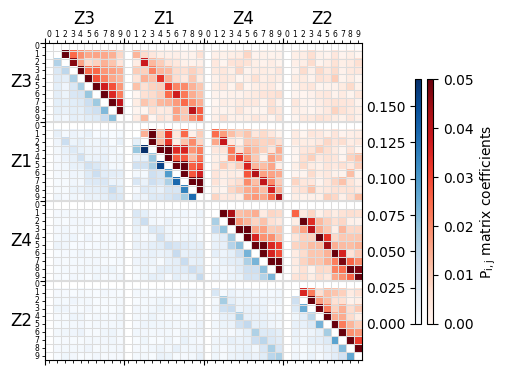

In [6]:
from qce_interp.visualization import plot_pij_matrix

plot_pij_matrix(
    error_identifier=error_identifier,
    included_rounds=list(range(1, 11)),
)

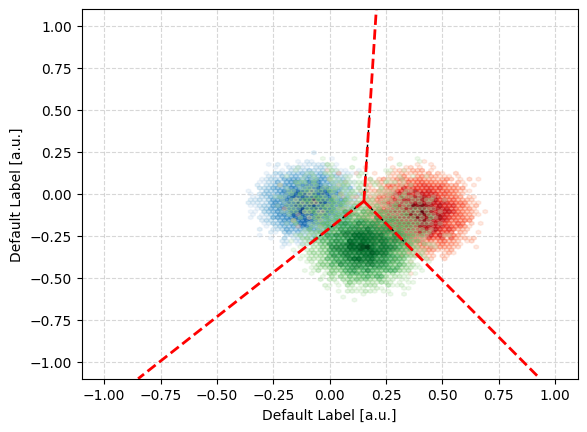

In [16]:
import numpy as np
from typing import List, Dict
from qce_interp.visualization.plotting_functionality import (
    construct_subplot,
    IFigureAxesPair,
    LabelFormat,
    AxesFormat,
    SubplotKeywordEnum,
)
from qce_interp.utilities.geometric_definitions import Vec2D
from qce_interp.interface_definitions.intrf_state_classification import (
    StateAcquisition,
    StateBoundaryKey,
)
from qce_interp import (
    StateAcquisitionContainer, 
    DecisionBoundaries,
    StateKey,
)
from matplotlib.colors import Colormap
from matplotlib import colormaps
from matplotlib import patches
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, PowerNorm
import matplotlib.pyplot as plt

def plot_state_shots(state_classifier: StateAcquisitionContainer, **kwargs) -> IFigureAxesPair:
    # Data allocation
    mincnt = 1
    min_x, max_x, min_y, max_y = -1, +1, -1, +1
    extent = [min_x, max_x, min_y, max_y]
    power_gamma: float = 0.3
    # Hardcoded color map
    colormap_lookup: Dict[int, Colormap] = {
        0: colormaps.get_cmap("Blues"),
        1: colormaps.get_cmap("Reds"),
        2: colormaps.get_cmap("Greens"),
        3: colormaps.get_cmap("Purples"),
    }

    # Figures and Axes
    fig, ax = construct_subplot(**kwargs)

    alpha_colormaps: List[ListedColormap] = []
    for colormap in colormap_lookup.values():
        sub_colormap: Colormap = colormap(np.arange(colormap.N))
        sub_colormap[:, -1] = np.linspace(0, 1, colormap.N)
        listed_colormap: ListedColormap = ListedColormap(sub_colormap)
        alpha_colormaps.append(listed_colormap)

    for state, state_acquisition in state_classifier.state_acquisition_lookup.items():
        ax.hexbin(
            x=state_acquisition.shots.real,
            y=state_acquisition.shots.imag,
            cmap=alpha_colormaps[state_acquisition.state.value],
            mincnt=mincnt,
            extent=extent,
            norm=PowerNorm(gamma=power_gamma),
        )
    return fig, ax

def get_neighboring_boundary_keys(state: StateKey, boundary_keys: List[StateBoundaryKey]) -> List[StateBoundaryKey]:
    return [boundary_key for boundary_key in boundary_keys if state in boundary_key]

def euclidean_distance(p1: Vec2D, p2: Vec2D):
    return np.sqrt((p2.x - p1.x)**2 + (p2.y - p1.y)**2)

def find_axes_intersection(start_point: Vec2D, other_point: Vec2D, ax: plt.Axes) -> Vec2D:
    x1, y1 = start_point.to_tuple()
    x2, y2 = other_point.to_tuple()
    min_x, max_x = ax.get_xlim()
    min_y, max_y = ax.get_ylim()
    
    potential_intersections = []
    start = Vec2D(x1, y1)
    other = Vec2D(x2, y2)

    # Handle the case where the line is vertical
    if x1 == x2:
        if min_y <= y1 <= max_y or min_y <= y2 <= max_y:
            potential_intersections.append(Vec2D(x=x1, y=max_y if y2 > y1 else min_y))

    else:
        # Calculate slope and y-intercept
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1

        # Check intersection with y-axis limits
        for y_limit in [min_y, max_y]:
            x_at_y = (y_limit - b) / m
            if min_x <= x_at_y <= max_x:
                potential_intersections.append(Vec2D(x=x_at_y, y=y_limit))

        # Check intersection with x-axis limits
        for x_limit in [min_x, max_x]:
            y_at_x = m * x_limit + b
            if min_y <= y_at_x <= max_y:
                potential_intersections.append(Vec2D(x=x_limit, y=y_at_x))

    # Find the closest intersection to other_point
    closest_intersection = None
    min_distance_to_other = float('inf')
    for intersection in potential_intersections:
        distance_to_other = euclidean_distance(intersection, other)
        if distance_to_other < min_distance_to_other:
            closest_intersection = intersection
            min_distance_to_other = distance_to_other

    return closest_intersection if closest_intersection else Vec2D(x=other_point[0], y=other_point[1])


def plot_decision_boundary(decision_boundaries: DecisionBoundaries, **kwargs) -> IFigureAxesPair:
    # Data allocation
    center: Vec2D = decision_boundaries.mean
    boundary_keys: List[StateBoundaryKey] = list(decision_boundaries.boundary_lookup.keys())

    # Figures and Axes
    fig, ax = construct_subplot(**kwargs)

    # Store the current limits
    original_xlim = ax.get_xlim()
    original_ylim = ax.get_ylim()
    for boundary_key in boundary_keys:
        boundary_point: Vec2D = decision_boundaries.get_boundary(key=boundary_key)
        limit_point: Vec2D = find_axes_intersection(start_point=center, other_point=boundary_point, ax=ax)
        ax.plot(
            [center.x, boundary_point.x],
            [center.y, boundary_point.y],
            linestyle='--',
            color='k',
            linewidth=1,
        )
        ax.plot(
            [center.x, limit_point.x],
            [center.y, limit_point.y],
            linestyle='--',
            color='r',
            linewidth=2,
        )
        # Restore the original limits
        ax.set_xlim(original_xlim)
        ax.set_ylim(original_ylim)

    return fig, ax

qubit_id = QubitIDObj('Z1')
state_classifier: StateAcquisitionContainer = data_manager.get_state_acquisition(qubit_id=qubit_id)
decision_boundaries: DecisionBoundaries = state_classifier.decision_boundaries
fig, ax = plot_state_shots(state_classifier=state_classifier)
fig, ax = plot_decision_boundary(decision_boundaries=decision_boundaries, host_axes=(fig, ax))

# ---- To refactor:
calibration_points: StateAcquisitionContainer = state_classifier
concatenated_shots: np.ndarray = calibration_points.concatenated_shots
decision_boundaries = calibration_points.decision_boundaries

# _lim = np.max([ np.max(np.abs(concatenated_shots.real))*1.1, np.max(np.abs(concatenated_shots.imag))*1.1 ])
# limit_points: Dict[StateBoundaryKey, Vec2D] = {}
# bound_keys: List[StateBoundaryKey] = [StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_1), StateBoundaryKey(StateKey.STATE_1, StateKey.STATE_2), StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_2)]
# for bound in bound_keys:
#     x = decision_boundaries.mean
#     _x0, _y0 = decision_boundaries.mean.to_tuple()
#     boundary = decision_boundaries.get_boundary(bound)
#     if boundary is None:
#         continue
    
#     _x1, _y1 = boundary.to_tuple()
#     ax.plot(
#         [_x1],
#         [_y1],
#         color='k',
#         marker='o',
#         linestyle='none',
#     )
#     a = (_y1-_y0)/(_x1-_x0)
#     b = _y0 - a*_x0
#     _xlim = 1e2*np.sign(_x1-_x0)
#     _ylim = a*_xlim + b
#     limit_points[bound] = Vec2D(x=_xlim, y=_ylim)

# for center in [state_acquisition.center for state_acquisition in calibration_points.state_acquisition_lookup.values()]:
#     ax.plot(
#         center.x,
#         center.y,
#         color='k',
#         marker='D',
#         linestyle='none',
#     )

# _lim = np.max([ np.max(np.abs(concatenated_shots.real))*1.1, np.max(np.abs(concatenated_shots.imag))*1.1 ])
# limit_points: Dict[StateBoundaryKey, Vec2D] = {}
# for bound in list(decision_boundaries.boundary_lookup.keys()):
#     x: Vec2D = decision_boundaries.mean
#     _x0, _y0 = decision_boundaries.mean.to_tuple()
#     boundary: Vec2D = decision_boundaries.get_boundary(bound)
#     if boundary is None:
#         continue
    
#     _x1, _y1 = boundary.to_tuple()
#     # ax.plot(
#     #     [_x1],
#     #     [_y1],
#     #     color='k',
#     #     marker='o',
#     #     linestyle='none',
#     # )
#     slope: float = (_y1-_y0)/(_x1-_x0)
#     b = _y0 - slope*_x0
#     _xlim = 1e2*np.sign(_x1-_x0)
#     _ylim = slope*_xlim + b
#     limit_points[bound] = Vec2D(x=_xlim, y=_ylim)

# # Plot 0 area
# _points = [decision_boundaries.mean.to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_1)].to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_2)].to_tuple()]
# _patch = patches.Polygon(_points, color='C0', alpha=0.2, lw=0)
# ax.add_patch(_patch)
# # Plot 1 area
# _points = [decision_boundaries.mean.to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_1)].to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_1, StateKey.STATE_2)].to_tuple()]
# _patch = patches.Polygon(_points, color='C3', alpha=0.2, lw=0)
# ax.add_patch(_patch)
# # Plot 2 area
# _points = [decision_boundaries.mean.to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_2)].to_tuple(), limit_points[StateBoundaryKey(StateKey.STATE_1, StateKey.STATE_2)].to_tuple()]
# _patch = patches.Polygon(_points, color='C2', alpha=0.2, lw=0)
# ax.add_patch(_patch)

# # # Plot decision boundary
# for bound in list(decision_boundaries.boundary_lookup.keys()):
#     _x0, _y0 = decision_boundaries.mean.to_tuple()
#     _x1, _y1 = limit_points[bound].to_tuple()
#     ax.plot([_x0, _x1], [_y0, _y1], 'k--', lw=1)
# ax.set_xlim(-_lim, _lim)
# ax.set_ylim(-_lim, _lim)
# ax.legend(frameon=False)
# ax.set_xlabel('Integrated voltage I')
# ax.set_ylabel('Integrated voltage Q')
# ax.set_title(f'IQ plot qubit {qubit_id.id}')

[(0.15197893782424673, -0.043375838493468634), (0.8053418288764079, 13.528293685896168)]
[(0.15197893782424673, -0.043375838493468634), (-0.8053418288764079, -1.0533003612422907)]
[(0.15197893782424673, -0.043375838493468634), (0.8053418288764079, -0.9268343508227828)]


(-0.8053418288764079, 0.8053418288764079)

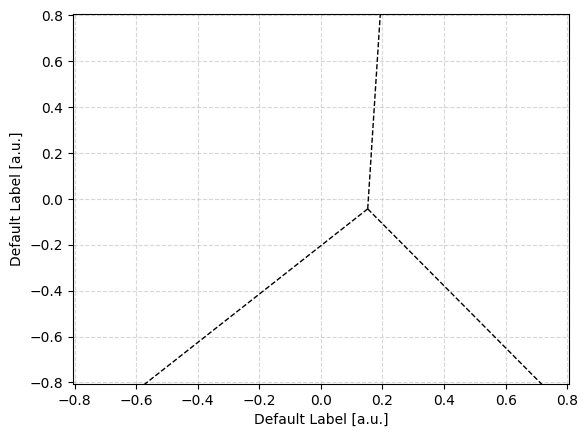

In [8]:
import numpy as np
import matplotlib.patches as patches
from typing import Dict, List, Tuple

fig, ax = construct_subplot()

def calculate_intersection(mean: Vec2D, boundary: Vec2D, limit: float) -> Vec2D:
    """
    Calculate the intersection of the boundary line with the plot axes.

    :param mean: Mean point (Vec2D).
    :param boundary: Boundary point (Vec2D).
    :param limit: Limit for the axes.
    :return: Intersection point (Vec2D).
    """
    _x0, _y0 = mean.to_tuple()
    _x1, _y1 = boundary.to_tuple()
    
    slope = (_y1 - _y0) / (_x1 - _x0)
    b = _y0 - slope * _x0
    _xlim = limit * np.sign(_x1 - _x0)
    _ylim = slope * _xlim + b

    return Vec2D(x=_xlim, y=_ylim)

def calculate_polygon_vertices(mean: Vec2D, boundary_points: List[Vec2D]) -> List[Tuple[float, float]]:
    """
    Calculate the vertices for the polygon.

    :param mean: Mean point (Vec2D).
    :param boundary_points: List of boundary points (Vec2D).
    :return: List of vertices (tuple of floats).
    """
    vertices = [mean.to_tuple()]
    vertices.extend([point.to_tuple() for point in boundary_points])
    return vertices

# Example usage
# Assuming decision_boundaries and concatenated_shots are defined

_lim = np.max([np.max(np.abs(concatenated_shots.real)) * 1.1, np.max(np.abs(concatenated_shots.imag)) * 1.1])
limit_points: Dict[StateBoundaryKey, Vec2D] = {}

for bound in list(decision_boundaries.boundary_lookup.keys()):
    boundary: Vec2D = decision_boundaries.get_boundary(bound)
    if boundary is None:
        continue
    
    limit_points[bound] = calculate_intersection(decision_boundaries.mean, boundary, _lim)

# Assuming ax is defined and decision_boundaries.mean is available
# Plot polygons and boundary lines using the refactored functions
for key, color in [(StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_1), 'C0'), 
                   (StateBoundaryKey(StateKey.STATE_0, StateKey.STATE_2), 'C3'), 
                   (StateBoundaryKey(StateKey.STATE_1, StateKey.STATE_2), 'C2')]:
    vertices = calculate_polygon_vertices(decision_boundaries.mean, [limit_points[key]])
    print(vertices)
    _patch = patches.Polygon(vertices, color=color, alpha=0.2, lw=0)
    ax.add_patch(_patch)

for bound, point in limit_points.items():
    _x0, _y0 = decision_boundaries.mean.to_tuple()
    _x1, _y1 = point.to_tuple()
    ax.plot([_x0, _x1], [_y0, _y1], 'k--', lw=1)

ax.set_xlim(-_lim, _lim)
ax.set_ylim(-_lim, _lim)
